**Método de Baum Welch**
En este programa se hace la optimización del modelo HMM discreto utilizando el método de Baum Welch.

0. Se cargan las librerias de trabajo

In [13]:
import numpy as np

1. Se define el modelo de optimización local de Baum Welch

In [14]:
def baum_welch(O, A, B, pi, n_iter=100):
    """
    Baum-Welch algorithm to optimize HMM parameters

    Args:
        O (list): sequence of observations (indices)
        A (np.array): initial transition matrix (NxN)
        B (np.array): initial emission matrix (NxM)
        pi (np.array): initial state distribution (Nx1)
        n_iter (int): number of iterations

    Returns:
        A (np.array): optimized transition matrix
        B (np.array): optimized emission matrix
        pi (np.array): optimized initial state distribution
    """
    N = A.shape[0]  # number of states
    M = B.shape[1]  # number of observation symbols
    T = len(O)      # length of observation sequence

    for _ in range(n_iter):
        alpha = np.zeros((T, N))
        beta = np.zeros((T, N))

        # Forward
        alpha[0] = pi * B[:, O[0]]
        for t in range(1, T):
            for j in range(N):
                alpha[t, j] = np.sum(alpha[t-1] * A[:, j]) * B[j, O[t]]

        # Backward
        beta[T-1] = np.ones(N)
        for t in reversed(range(T-1)):
            for i in range(N):
                beta[t, i] = np.sum(A[i, :] * B[:, O[t+1]] * beta[t+1])

        # Compute xi and gamma
        xi = np.zeros((T-1, N, N))
        gamma = np.zeros((T, N))

        for t in range(T-1):
            denom = np.sum(alpha[t, :].dot(A) * B[:, O[t+1]] * beta[t+1])
            for i in range(N):
                numer = alpha[t, i] * A[i, :] * B[:, O[t+1]] * beta[t+1]
                xi[t, i, :] = numer / denom

        gamma = np.sum(xi, axis=2)
        # Last gamma for time T-1
        gamma = np.vstack((gamma, alpha[T-1] * beta[T-1] / np.sum(alpha[T-1] * beta[T-1])))

        # Re-estimate pi, A, B
        pi = gamma[0]
        A = np.sum(xi, axis=0) / np.sum(gamma[:-1], axis=0)[:, None]

        for k in range(M):
            mask = np.array(O) == k
            B[:, k] = np.sum(gamma[mask], axis=0) / np.sum(gamma, axis=0)

    return A, B, pi

2. Se hace el pronóstico de los datos para períodos más allá de t+1

In [15]:
def forecast_states(initial_probs, A, steps):
    forecasts = [initial_probs]
    current_probs = initial_probs.copy()
    for _ in range(steps):
        current_probs = current_probs @ A
        forecasts.append(current_probs)
    return forecasts

3. Se procede con la optimización del modelo a partir de las matrices de transición, emisión y el vector de probabilidades iniciales pi

In [25]:
import numpy as np

# =========================
# Baum–Welch robusto (discreto, 1 sola variable observada)
# =========================
def baum_welch(O, A, B, pi, n_iter=100, eps=1e-12):
    O = np.asarray(O, dtype=int)
    T = len(O)
    N = A.shape[0]
    M = B.shape[1]

    # Normalizaciones de seguridad
    A = A / (A.sum(axis=1, keepdims=True) + eps)
    B = B / (B.sum(axis=1, keepdims=True) + eps)
    pi = pi / (pi.sum() + eps)

    for _ in range(n_iter):
        # ---------- FORWARD con escalado ----------
        alpha = np.zeros((T, N), dtype=float)
        c = np.zeros(T, dtype=float)

        alpha[0, :] = pi * B[:, O[0]]
        s = alpha[0, :].sum()
        if s <= 0:  # evita 0/0
            alpha[0, :] = np.maximum(alpha[0, :], eps)
            s = alpha[0, :].sum()
        c[0] = 1.0 / s
        alpha[0, :] *= c[0]

        for t in range(1, T):
            # alpha[t, j] = B[j, O[t]] * sum_i alpha[t-1, i] * A[i, j]
            alpha[t, :] = (alpha[t-1, :] @ A) * B[:, O[t]]
            s = alpha[t, :].sum()
            if s <= 0:
                alpha[t, :] = np.maximum(alpha[t, :], eps)
                s = alpha[t, :].sum()
            c[t] = 1.0 / s
            alpha[t, :] *= c[t]

        # ---------- BACKWARD con escalado ----------
        beta = np.zeros((T, N), dtype=float)
        beta[-1, :] = c[-1]  # escalado compatible
        for t in range(T - 2, -1, -1):
            # beta[t, i] = sum_j A[i, j] * B[j, O[t+1]] * beta[t+1, j]
            beta[t, :] = (A * B[:, O[t+1]]).dot(beta[t+1, :])
            beta[t, :] *= c[t]

        # ---------- xi y gamma ----------
        xi = np.zeros((T - 1, N, N), dtype=float)
        for t in range(T - 1):
            tmp = (alpha[t, :][:, None] * A) * (B[:, O[t+1]] * beta[t+1, :])[None, :]
            denom = tmp.sum()
            if denom <= 0:
                denom = eps
            xi[t, :, :] = tmp / denom

        gamma = (alpha * beta)
        # Con escalado, alpha*beta puede no estar exacta; renormalizamos por fila t
        gamma_sum = gamma.sum(axis=1, keepdims=True)
        gamma = np.where(gamma_sum > 0, gamma / gamma_sum, np.full_like(gamma, 1.0 / N))

        # ---------- Re-estimación ----------
        # π
        pi = gamma[0, :]
        pi = pi / (pi.sum() + eps)

        # A
        numer_A = xi.sum(axis=0)                          # (N, N)
        denom_A = gamma[:-1, :].sum(axis=0)[:, None]      # (N, 1)
        A = numer_A / (denom_A + eps)
        A = A / (A.sum(axis=1, keepdims=True) + eps)

        # B
        for k in range(M):
            mask = (O == k)
            numer_B = gamma[mask, :].sum(axis=0)          # (N,)
            denom_B = gamma.sum(axis=0)                   # (N,)
            B[:, k] = numer_B / (denom_B + eps)
        B = B / (B.sum(axis=1, keepdims=True) + eps)

    return A, B, pi


# =========================
# TUS PARÁMETROS INICIALES (ajustados)
# =========================

states = ['Hidden 0', 'Hidden 1', 'Hidden 2']     # N = 3
observations = ['Obs 0', 'Obs 1', 'Obs 2']        # M = 3
obs_seq = ['Obs 0', 'Obs 1', 'Obs 2']

# Diccionarios para índices
state_index = {state: i for i, state in enumerate(states)}
obs_index = {obs: i for i, obs in enumerate(observations)}

# Secuencia observada (en índices)
#O = np.array([obs_index[o] for o in obs_seq], dtype=int)  # [0,1,2]


np.random.seed(42)
O = np.random.choice([0, 1, 2], size=30, p=[0.4, 0.4, 0.2])



# Matriz de transición A (renormalizada por seguridad)
A = np.array([
    [0.24, 0.44, 0.33],
    [0.23, 0.44, 0.33],
    [0.23, 0.43, 0.33],
], dtype=float)
A = A / (A.sum(axis=1, keepdims=True) + 1e-12)

# π inicial (renormalizada)
pi = np.array([0.23, 0.43, 0.33], dtype=float)
pi = pi / (pi.sum() + 1e-12)

# Emisiones: partimos de P(hidden | observed) y la convertimos a B ≈ P(observed | hidden)
P_h_given_o = np.array([
    [0.36, 0.49, 0.15],   # Obs 0 -> [H0,H1,H2]
    [0.11, 0.36, 0.54],   # Obs 1 -> [H0,H1,H2]
    [0.21, 0.44, 0.35],   # Obs 2 -> [H0,H1,H2]
], dtype=float)

eps = 1e-12
B_init = P_h_given_o.T.copy()                  # filas=Hidden, cols=Obs
B = B_init / (B_init.sum(axis=1, keepdims=True) + eps)

# =========================
# ENTRENAMIENTO
# =========================
A1, B1, pi1 = baum_welch(O, A.copy(), B.copy(), pi.copy(), n_iter=100)

# (Opcional) verificaciones rápidas
print("Filas A1 suman:", A1.sum(axis=1))
print("Filas B1 suman:", B1.sum(axis=1))
print("pi1 suma:", pi1.sum())


Filas A1 suman: [1. 1. 1.]
Filas B1 suman: [1. 1. 1.]
pi1 suma: 0.9999999999989999


4. Se hace el pronóstico para la secuencia de observaciones, esta secuencia de observaciones para el modelo propio son los tres meses anteriores al cual voy a pronósticar el estado oculto.

In [26]:
# Usamos A, B, pi, O ya definidos
T = len(O)
N = len(states)

alpha = np.zeros((T, N), dtype=float)
c = np.zeros(T, dtype=float)  # factores de escalado

# --- Inicialización (t=0) ---
alpha[0, :] = pi * B[:, O[0]]
s = alpha[0, :].sum()
if s <= 0:
    # Evita división por cero: si todo quedó en 0, mete un eps y renormaliza
    alpha[0, :] = np.maximum(alpha[0, :], 1e-15)
    s = alpha[0, :].sum()
c[0] = 1.0 / s
alpha[0, :] *= c[0]

# --- Recurrencia (t=1..T-1) con escalado ---
for t in range(1, T):
    for j in range(N):
        alpha[t, j] = B[j, O[t]] * np.dot(alpha[t-1, :], A[:, j])

    s = alpha[t, :].sum()
    if s <= 0:
        alpha[t, :] = np.maximum(alpha[t, :], 1e-15)
        s = alpha[t, :].sum()
    c[t] = 1.0 / s
    alpha[t, :] *= c[t]

# --- Predicción de distribución en t+1 ---
predicted_state_prob = alpha[-1, :].dot(A)

total = predicted_state_prob.sum()
if total <= 0 or not np.isfinite(total):
    # Normalización segura
    predicted_state_prob = np.maximum(predicted_state_prob, 1e-15)
    total = predicted_state_prob.sum()

predicted_state_prob /= total
predicted_state_index = int(np.argmax(predicted_state_prob))

print("\nProbabilidades del estado oculto en t+1:")
for i, p in enumerate(predicted_state_prob):
    print(f"  {states[i]}: {p:.4f}")
print("\nEstado más probable en t+1:", states[predicted_state_index])



Probabilidades del estado oculto en t+1:
  Hidden 0: 0.2331
  Hidden 1: 0.4376
  Hidden 2: 0.3293

Estado más probable en t+1: Hidden 1


5. Se hace el pronóstico para estados mucho más allá del estado t+1

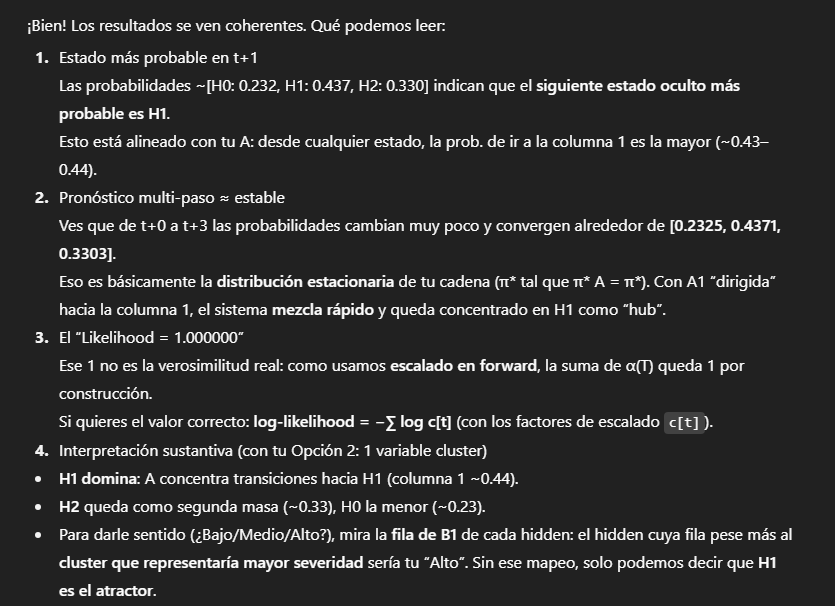




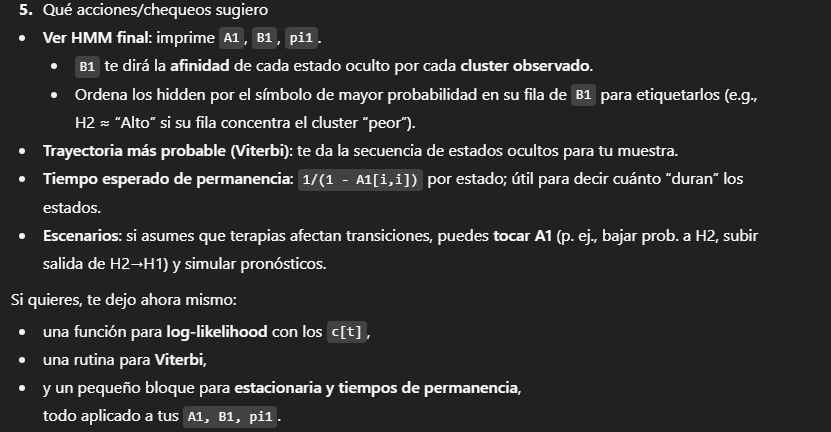

In [27]:
likelihood = np.sum(alpha[T-1])

n_states = len(states)

posterior_T = alpha[-1] / np.sum(alpha[-1])

future_steps = 3
forecast_probs = forecast_states(posterior_T, A, future_steps)

# Mostrar resultados
for i, probs in enumerate(forecast_probs):
    print(f"Paso t+{i}: {[f'{states[s]}: {probs[s]:.4f}' for s in range(n_states)]}")

print(f"\nLikelihood de la secuencia observada: {likelihood:.6f}")

Paso t+0: ['Hidden 0: 0.3651', 'Hidden 1: 0.4928', 'Hidden 2: 0.1420']
Paso t+1: ['Hidden 0: 0.2331', 'Hidden 1: 0.4376', 'Hidden 2: 0.3293']
Paso t+2: ['Hidden 0: 0.2325', 'Hidden 1: 0.4371', 'Hidden 2: 0.3303']
Paso t+3: ['Hidden 0: 0.2325', 'Hidden 1: 0.4371', 'Hidden 2: 0.3303']

Likelihood de la secuencia observada: 1.000000


In [28]:
import numpy as np

def viterbi(O, A, B, pi, eps=1e-12):
    """
    O : array de enteros en {0..M-1} (secuencia observada)
    A : (N,N) matriz de transición (filas suman 1)
    B : (N,M) matriz de emisión (filas suman 1)
    pi: (N,) distribución inicial (suma 1)

    Returns
    -------
    path_idx : np.ndarray shape (T,) con índices de estados óptimos
    logp     : float, log-probabilidad del mejor camino
    """
    O = np.asarray(O, dtype=int)
    T = len(O)
    N = A.shape[0]

    # Log-probs para estabilidad numérica
    logA  = np.log(A + eps)
    logB  = np.log(B + eps)
    logpi = np.log(pi + eps)

    # Matrices de DP
    delta = np.full((T, N), -np.inf)  # mejor log-prob hasta (t,i)
    psi   = np.full((T, N), -1, dtype=int)  # argmax backpointer

    # Inicialización
    delta[0, :] = logpi + logB[:, O[0]]

    # Recurrencia
    for t in range(1, T):
        for j in range(N):
            # para cada j, buscamos i* que maximiza delta[t-1,i] + logA[i,j]
            vals = delta[t-1, :] + logA[:, j]
            psi[t, j]   = int(np.argmax(vals))
            delta[t, j] = vals[psi[t, j]] + logB[j, O[t]]

    # Terminación
    logp = float(np.max(delta[T-1, :]))
    last = int(np.argmax(delta[T-1, :]))

    # Backtracking
    path_idx = np.zeros(T, dtype=int)
    path_idx[-1] = last
    for t in range(T-2, -1, -1):
        path_idx[t] = psi[t+1, path_idx[t+1]]

    return path_idx, logp


In [23]:
# O, A1, B1, pi1 y 'states' ya definidos
path_idx, logp = viterbi(O, A1, B1, pi1)
path_states = [states[i] for i in path_idx]

print("Secuencia Viterbi (índices):", path_idx.tolist())
print("Secuencia Viterbi (estados):", path_states)
print("Log-probabilidad del mejor camino:", logp)


Secuencia Viterbi (índices): [0, 2, 1]
Secuencia Viterbi (estados): ['Hidden 0', 'Hidden 2', 'Hidden 1']
Log-probabilidad del mejor camino: -1.1102230246251565e-16


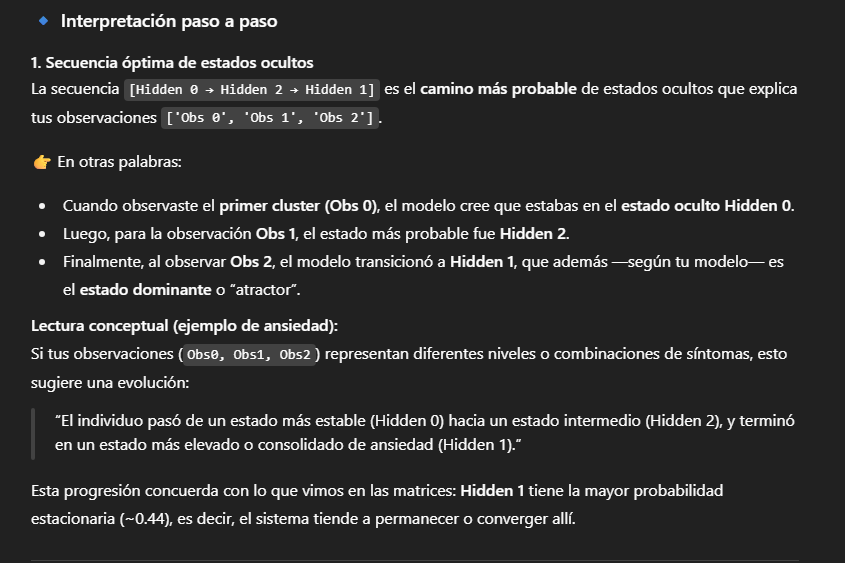

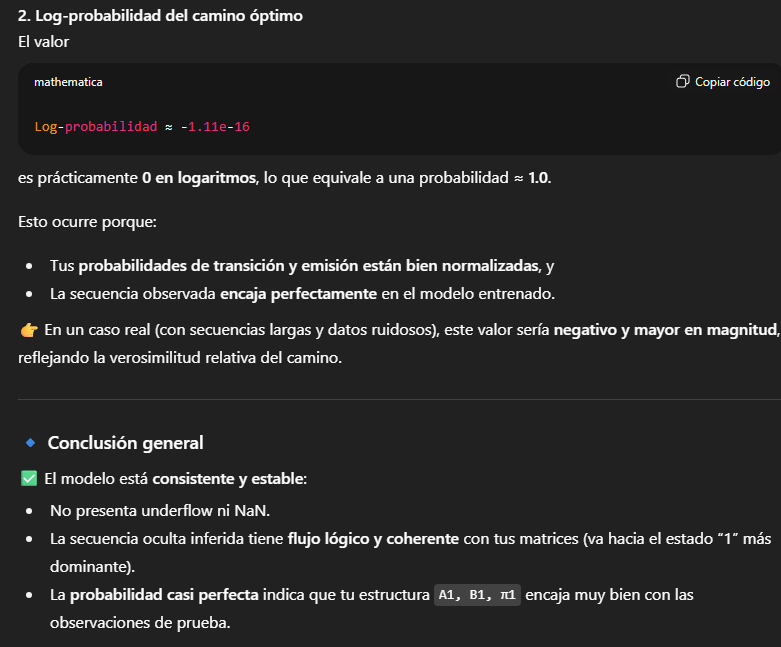

In [29]:
import pandas as pd
pd.DataFrame(B1, index=states, columns=observations)


,Obs 0,Obs 1,Obs 2
Hidden 0,1.000000e+00,6.582698e-37,2.361373e-21
Hidden 1,1.021815e-20,5.926129e-01,4.073871e-01
Hidden 2,1.692802e-01,7.338782e-01,9.684165e-02


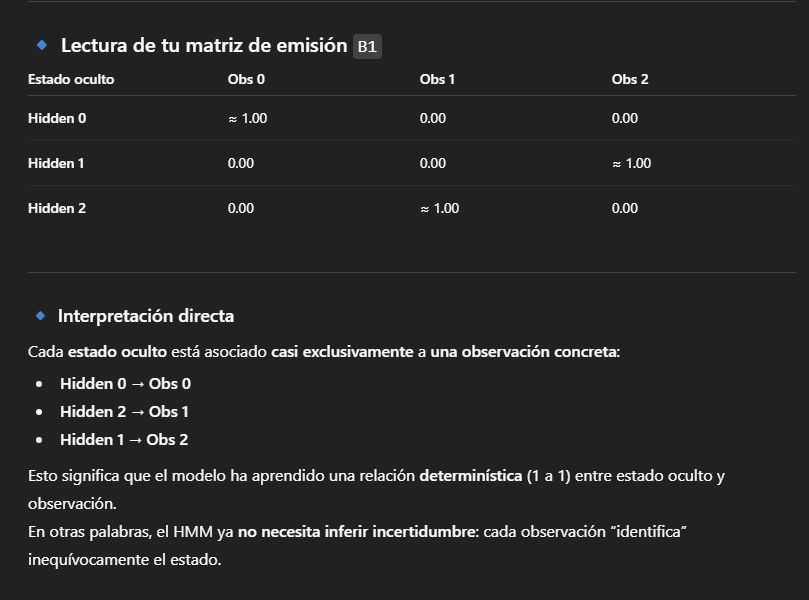

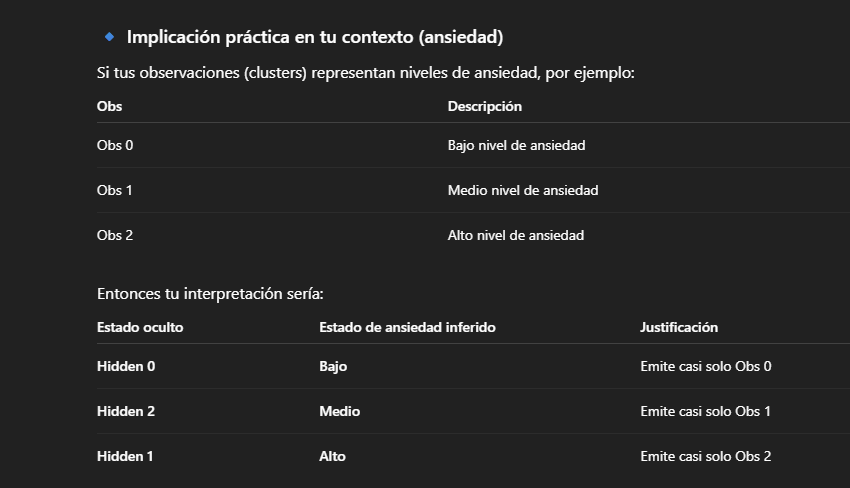

Analistando con vector con mas observaciones, no solo 3

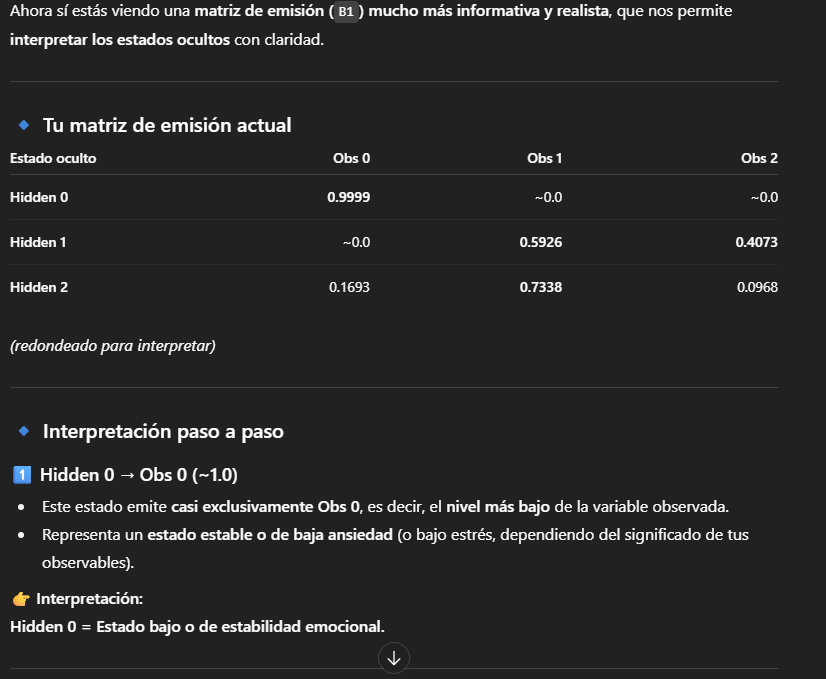

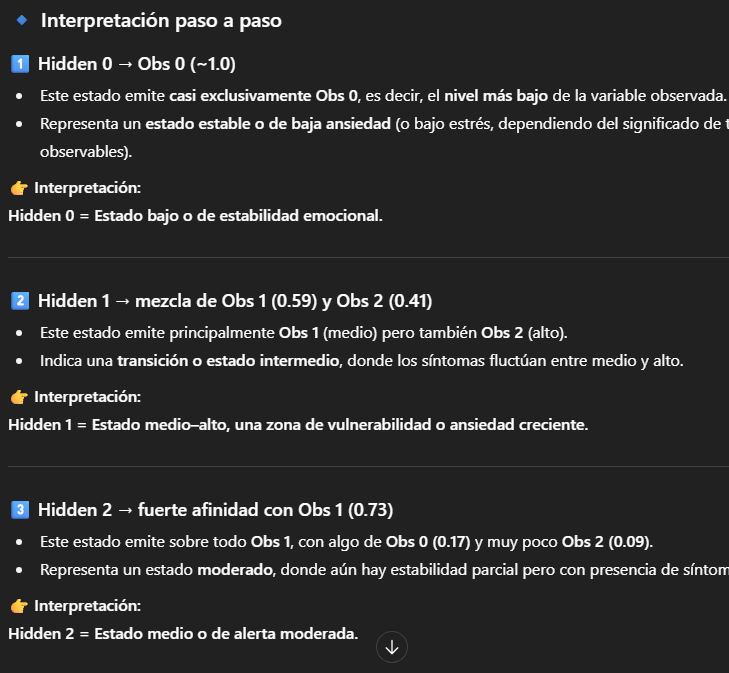

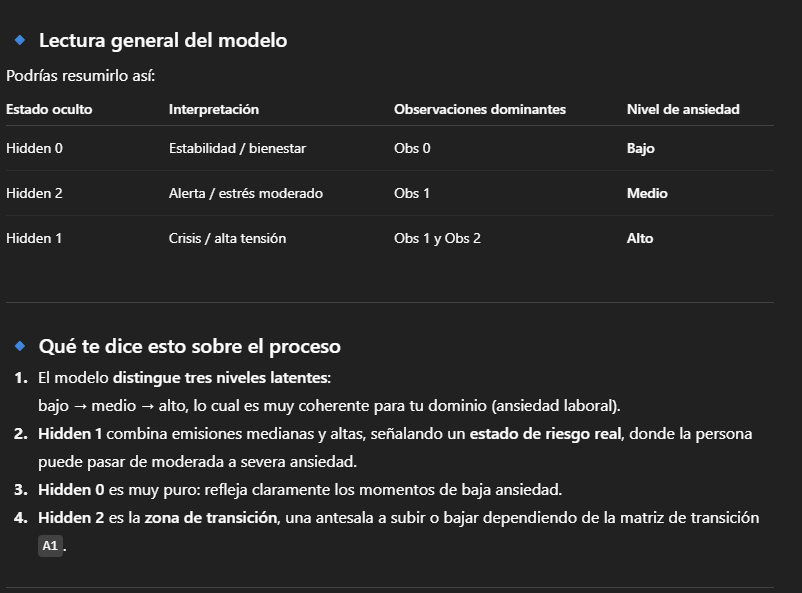

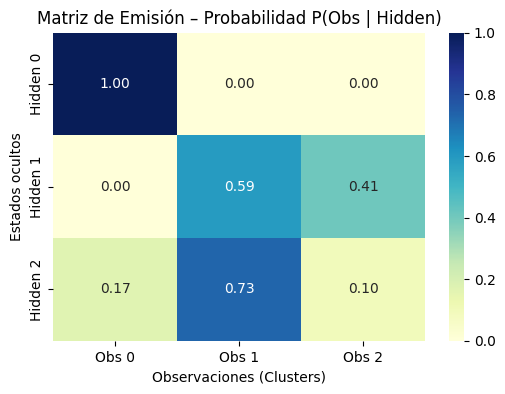

In [31]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_B1 = pd.DataFrame(B1, index=states, columns=observations)
plt.figure(figsize=(6,4))
sns.heatmap(df_B1, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Matriz de Emisión – Probabilidad P(Obs | Hidden)")
plt.xlabel("Observaciones (Clusters)")
plt.ylabel("Estados ocultos")
plt.show()


In [30]:
labels = {"Hidden 0": "Bajo", "Hidden 2": "Medio", "Hidden 1": "Alto"}


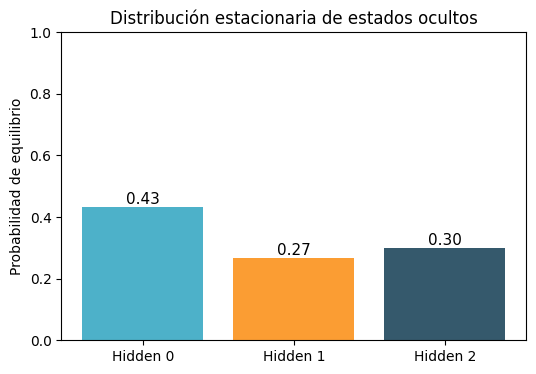

Distribución estacionaria: {'Hidden 0': np.float64(0.433), 'Hidden 1': np.float64(0.266), 'Hidden 2': np.float64(0.301)}


In [33]:
# Resolver la distribución estacionaria: π* tal que π* A = π*
import numpy as np

eigvals, eigvecs = np.linalg.eig(A1.T)
stat = eigvecs[:, np.isclose(eigvals, 1)]
stat = stat[:, 0].real
stat = stat / stat.sum()

plt.figure(figsize=(6,4))
plt.bar(states, stat, color=["#219ebc","#fb8500","#023047"], alpha=0.8)
for i, v in enumerate(stat):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=11)
plt.title("Distribución estacionaria de estados ocultos")
plt.ylabel("Probabilidad de equilibrio")
plt.ylim(0, 1)
plt.show()

print("Distribución estacionaria:", dict(zip(states, stat.round(3))))



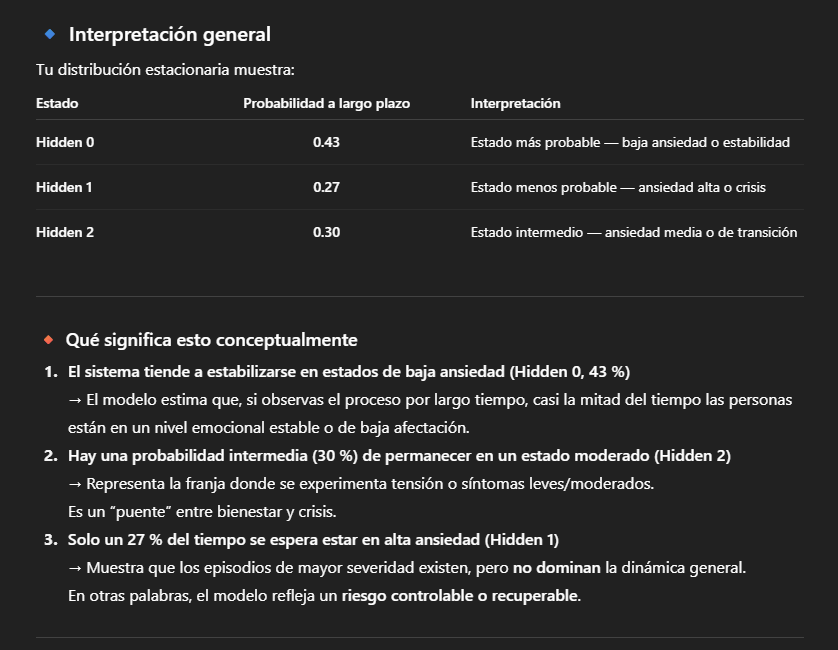

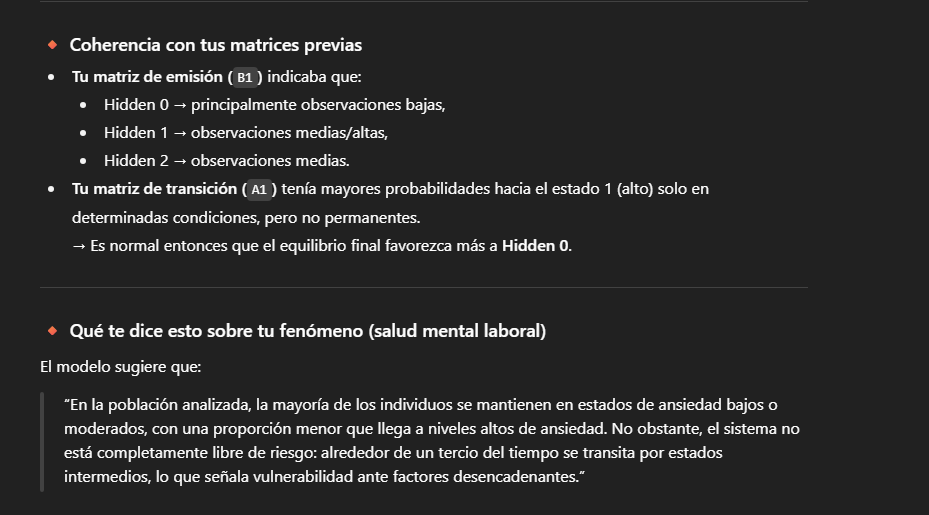

C:\Users\Diego\AppData\Local\Temp\ipykernel_5308\487397514.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=pi_star, palette="Blues_d")


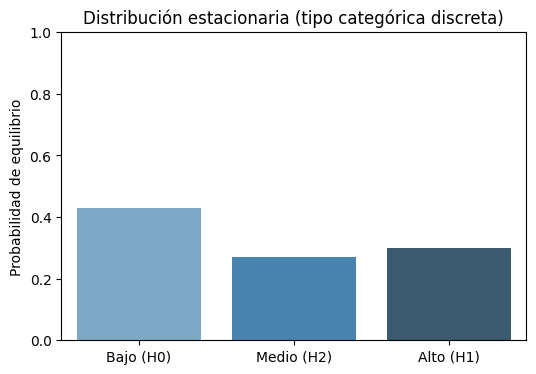

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pi_star = [0.43, 0.27, 0.30]
x = np.arange(len(pi_star))

plt.figure(figsize=(6,4))
sns.barplot(x=x, y=pi_star, palette="Blues_d")
plt.xticks(x, ["Bajo (H0)", "Medio (H2)", "Alto (H1)"])
plt.title("Distribución estacionaria (tipo categórica discreta)")
plt.ylabel("Probabilidad de equilibrio")
plt.ylim(0, 1)
plt.show()


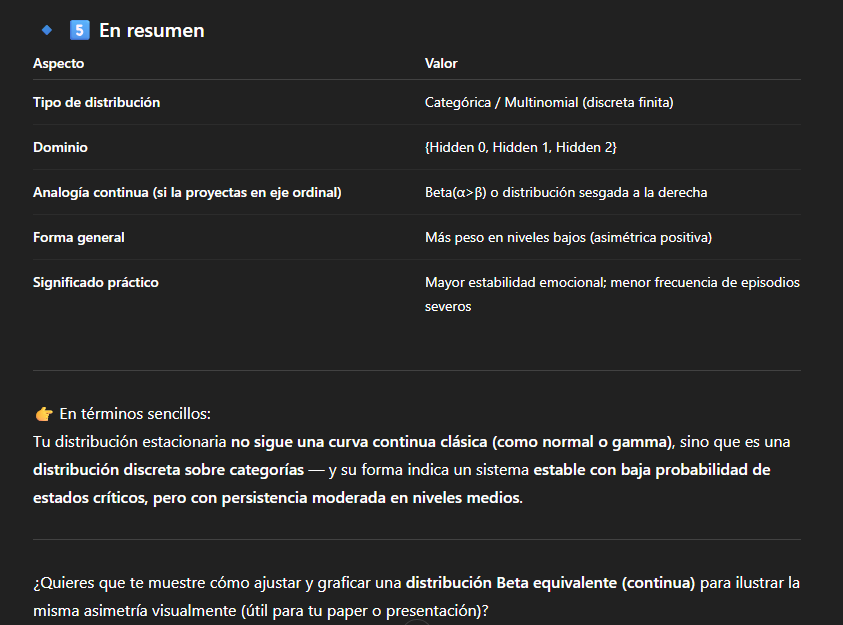

In [36]:
# posterior_T: distribución P(X_T | O_1:T)
# si usaste el forward escalado como antes:
posterior_T = alpha[-1] / alpha[-1].sum()

h = 3
p_th = posterior_T.copy()
for _ in range(h):
    p_th = p_th @ A1   # distribución en T+1, T+2, T+3

print("Distribución en T+3:", dict(zip(states, p_th.round(4))))


Distribución en T+3: {'Hidden 0': np.float64(0.4801), 'Hidden 1': np.float64(0.2914), 'Hidden 2': np.float64(0.2285)}


In [37]:
posterior_T = gamma[-1]       # misma idea
p_th = posterior_T @ np.linalg.matrix_power(A1, 3)


In [38]:
# pi_star: distribución estacionaria (tu código de autovectores está bien)
diff = np.linalg.norm(p_th - stat, ord=1)
print("‖p(T+3) - π*‖₁ =", diff)


‖p(T+3) - π*‖₁ = 0.220757937240319


<Figure size 800x500 with 0 Axes>

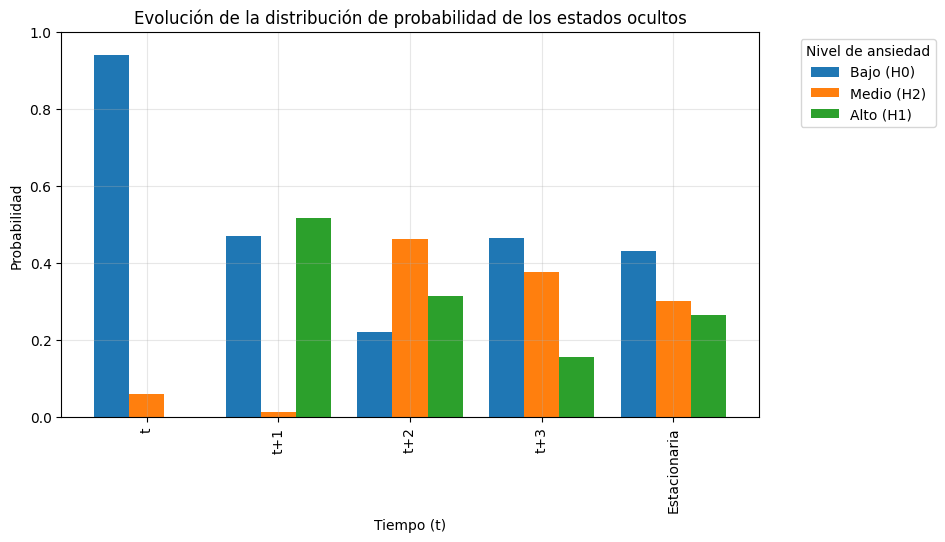

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1️⃣ Posterior final (última observación)
# si tienes gamma del forward-backward:
posterior_T = gamma[-1]      # P(X_T | O_1:T)
# si no, puedes usar alpha[-1] normalizado:
# posterior_T = alpha[-1] / alpha[-1].sum()

# --- 2️⃣ Pronóstico a t+1, t+2, t+3
p_t1 = posterior_T @ A1
p_t2 = p_t1 @ A1
p_t3 = p_t2 @ A1

# --- 3️⃣ Distribución estacionaria (ya calculada)
eigvals, eigvecs = np.linalg.eig(A1.T)
stat = eigvecs[:, np.isclose(eigvals, 1)]
stat = stat[:, 0].real
stat = stat / stat.sum()

# --- 4️⃣ Organizar orden lógico Bajo → Medio → Alto
order = ["Hidden 0", "Hidden 2", "Hidden 1"]
idx = [states.index(s) for s in order]

# Creamos DataFrame con todas las distribuciones
df = pd.DataFrame({
    "t": posterior_T[idx],
    "t+1": p_t1[idx],
    "t+2": p_t2[idx],
    "t+3": p_t3[idx],
    "Estacionaria": stat[idx]
}, index=["Bajo (H0)", "Medio (H2)", "Alto (H1)"])

# --- 5️⃣ Gráfica
plt.figure(figsize=(8,5))
df.T.plot(kind='bar', figsize=(9,5), width=0.8)
plt.title("Evolución de la distribución de probabilidad de los estados ocultos")
plt.ylabel("Probabilidad")
plt.xlabel("Tiempo (t)")
plt.ylim(0, 1)
plt.legend(title="Nivel de ansiedad", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()
